In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import copy
import os
import math
import datetime
import time
import operator
from numpy import sqrt
from tqdm.notebook import tqdm
from scipy import linalg
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True)

#-------------------
class Data:
    def __init__(self,x,y,u,id):
        #説明変数
        self.x = x
        #目的変数
        self.y = y
        self.u = u #抽出クラスタかノイズクラスタかどうか
        self.id = id
        self.cluster_number = 0 #最終的なクラスタ番号
#-------------------        
        
    

In [38]:
class GPSCRM:
    #-------------------
    def __init__(self,X,Y,alpha,lam,D,labels,max_iter,random_seed):
        self.X = X
        self.Y = Y        
        self.xx = np.linspace(np.min(X)-1 , np.max(X)+1 , 500)
        self.alpha = alpha
        self.lam = lam
        self.D = D
        self.labels = labels
        self.max_iter = max_iter
        self.random_seed = random_seed
        np.random.seed(random_seed)
    #-------------------
        
    #-------------------
    def plot(self,model,path):
        N = self.X.shape[0]
        c = ["b","r","g","c","m","y","k","w"]
        markers = ["o","+","x","v","o", "^", "<", ">"]
        plt.figure(figsize=(5,5))
        plt.xlim(np.min(self.X)-1,np.max(self.X)+1,1)
        plt.ylim(np.min(self.Y)-1,np.max(self.Y)+1,1)
        plt.xlabel("x")
        plt.ylabel("y")
        data_list = model.ex_data_list
        #データ点の散布図のプロット．クラスタごとに色分けして出力する．
        for k in range(len(data_list)):
            c_num = data_list[k].cluster_number
            #多次元version
            plt.scatter(data_list[k].x[0],data_list[k].y,marker=markers[c_num],s=35,c=c[c_num])
            #二次元version
            #plt.scatter(data_list[k].x,data_list[k].y,marker=markers[c_num],s=35,c=c[c_num])
            
        #期待値のプロット．
        for i in range(model.n_cluster):
            if i > 3:
                continue
            plt.plot(model.xx,model.display_exp_list[i],c=c[i])
        
        #分散のプロット
        for i in range(model.n_cluster):
            if i > 2:
                continue
            plt.fill_between(model.xx,model.display_exp_list[i] - 2 * sqrt(model.display_var_list[i]),model.display_exp_list[i] + 2 * sqrt(model.display_var_list[i]),alpha = 0.5,color=c[i])

        plt.savefig(os.path.join(path)+"figure.png")
        plt.show()
    #-------------------
    
    #-------------------
    def sequential_plot(self,exp_list,var_list,data_list):
        X = []
        Y = []
        for i in range(len(data_list)):
            X.append(data_list[i].x)
            Y.append(data_list[i].y)
        X = np.array(X)
        Y = np.array(Y)
        N = X.shape[0]
        x = np.arange(np.amin(X),np.amax(X) + 1)
        std = []
        c = ["r","b"]
        markers = ["+","o"]
        plt.figure(figsize=(5,5))
        plt.xlim(np.min(X)-1,np.max(X)+1,1)
        plt.ylim(np.min(Y)-1,np.max(Y)+1,1)
        plt.xlabel("x")
        plt.ylabel("y")
        for i in range(N):
            plt.scatter(X[i],Y[i],marker=markers[data_list[i].u],s=35,c = c[data_list[i].u])
        #期待値のプロット．
        plt.plot(self.xx,exp_list,c=c[1])
        plt.fill_between(self.xx,exp_list - 2 * sqrt(var_list),exp_list + 2 * sqrt(var_list),alpha = 0.5,color=c[1])
        plt.show()
    #-------------------

    #-------------------
    def kernel_matrix(self,X):
        N = len(X)
        K = np.zeros((N , N))
        eta = 1e-6
        for i in range(N):
            for j in range(N):
                K[i , j] = self.gauss(X[i] , X[j])
        K = K + eta*np.eye(N)
        return K
    #-------------------

    #-------------------
    def calc_k_a(self,X,xx):
        N = len(X)
        k_a = np.zeros(N)
        for i in range(N):
            k_a[i] = self.gauss(X[i],xx)
        return k_a
    #-------------------

    #-------------------
    def update_U(self,data_list,noise_param,exp_list):
        for i in range(len(data_list)):
            distance = (data_list[i].y - exp_list[i])**2
            if distance <= noise_param:
                data_list[i].u = 1
            else:
                data_list[i].u = 0
    #-------------------
    
    #-------------------
    def sort_ex_data_list(self):
        N = len(self.ex_data_list)
        for i in range(N):
            swap = False
            for j in range(N-1,i,-1):
                if self.ex_data_list[j-1].id > self.ex_data_list[j].id:
                    self.ex_data_list[j-1],self.ex_data_list[j] = self.ex_data_list[j],self.ex_data_list[j-1]
                    swap = True
            if swap == False:
                break
    #-------------------
    
    #-------------------
    def calc_ARI(self):
        #dataIDに基づいて，ex_data_listをソートする．
        self.sort_ex_data_list()
        N = len(self.ex_data_list)
        predict_labels = np.zeros([N])
        for k in range(N):
                predict_labels[k] = self.ex_data_list[k].cluster_number
        # print("正解ラベル",self.labels)
        # print(self.labels.shape)
        # print("U_list:",predict_labels)
        # print(predict_labels.shape)
    
        #predict = []
        #predicted_label = np.argmax(U,axis=0)
        ARI = adjusted_rand_score(self.labels,predict_labels)
        return ARI
    #-------------------
    
    #-------------------
    def calc_MAE(self,data_list,exp_list):
        y_true = []
        y_pred = []
        for i in range(len(data_list)):
            if(data_list[i].u == 1):
                y_true.append(data_list[i].y)
                y_pred.append(exp_list[i])
        if len(y_true) == 0:
            return np.nan
        return np.sqrt(mean_absolute_error(y_true, y_pred))
    #-------------------
    
    #-------------------
    def calc_RMSE(self,data_list,exp_list):
        y_true = []
        y_pred = []
        for i in range(len(data_list)):
            if(data_list[i].u == 1):
                y_true.append(data_list[i].y)
                y_pred.append(exp_list[i])
        if len(y_true) == 0:
            return np.nan
        return np.sqrt(mean_squared_error(y_true, y_pred))
    #-------------------
    
    #-------------------
    def calc_r2_score(self,data_list,exp_list):
        y_true = []
        y_pred = []
        for i in range(len(data_list)):
            if(data_list[i].u == 1):
                y_true.append(data_list[i].y)
                y_pred.append(exp_list[i])
        if len(y_true) == 0:
            return np.nan
        return r2_score(y_true, y_pred) 
    #-------------------
    
    #-------------------
    def calc_is_convergence(self,pre_data_list,data_list):
        N = len(data_list)
        pre_U = np.zeros([N])
        U = np.zeros([N])
        for k in range(N):
            pre_U[k] = pre_data_list[k].u
            U[k] = data_list[k].u
        return all(pre_U == U)
    #-------------------
    
    #-------------------
    def print_info(self,model,time):
        print("クラスタ数:",model.n_cluster)
        print("ARIの値:",model.ARI)
        print("RMSEの値:",model.RMSE_list)
        print("MAEの値:",model.MAE_list)
        print("r2scoreの値:",model.r2_score_list)
        print("実行時間:",time) 
        print("")
    #-------------------
    
    #-------------------
    def log_save(self,path,model,time):
        d_today = datetime.date.today()
        d_now = datetime.datetime.now() 
        f = open(path +"log.txt", 'w')
        f.write("実験に使用した記録まとめ\n")
        f.write(str(d_now) + "\n")
        f.write("クラスタ数:" + str(model.n_cluster) + "\n")
        f.write("ARIの値:" + str(model.ARI) + "\n")
        f.write("RMSEの値:" + str(model.RMSE_list) + "\n")
        f.write("MAEの値:" + str(model.MAE_list) + "\n")
        f.write("R2score(決定係数)の値:" + str(model.r2_score_list) + "\n")
        f.write("実行時間:" + str(time) + "\n")
        f.write("random_seed値:" + str(model.random_seed) +"\n") 
        f.write("ノイズパラメータD:" + str(model.D) + "\n")
        f.write("カーネルパラメータα:" + str(model.alpha) + "\n")
        f.write("正則化パラメータλ:" + str(model.lam) +"\n")
        f.close()
    #-------------------
    
    #-------------------
    def extract_cluster_data(self,data_list):
        c_x = []
        c_y = []
        for i in range(len(data_list)):
            if data_list[i].u == 1:
                c_x.append(data_list[i].x)
                c_y.append(data_list[i].y)
        c_x = np.array(c_x)
        c_y = np.array(c_y)
        return c_x,c_y
    #-------------------
    
    #-------------------
    def gp_calc_exp_var(self,data_list):
        N = len(self.X)
        exp_list = np.zeros(N)
        var_list = np.zeros(N)
        #抽出クラスタに属するデータのみを集めたリスト
        c_x , c_y = self.extract_cluster_data(data_list)
        K = self.kernel_matrix(c_x)
        k_inv_ridge = np.linalg.inv(K + self.lam * np.eye(len(c_x)))
        #k_inv_ridge = np.linalg.inv(K)
        for i,x in enumerate (self.X):
            k_a = self.calc_k_a(c_x,x)
            k_aa = self.gauss(x,x) + self.lam
            exp_list[i] = k_a.T @ k_inv_ridge @ c_y
            var_list[i] = k_aa - k_a.T @ k_inv_ridge @ k_a
        return exp_list,var_list
    #------------------
    
    #-------------------
    def display_calc(self,data_list):
        exp_list = np.zeros(self.xx.shape)
        var_list = np.zeros(self.xx.shape)
        #抽出クラスタに属するデータのみを集めたリスト
        c_x , c_y = self.extract_cluster_data(data_list)
        K = self.kernel_matrix(c_x)
        k_inv_ridge = np.linalg.inv(K + self.lam * np.eye(len(c_x)))
        #k_inv_ridge = np.linalg.inv(K)
        for i,x in enumerate (self.xx):
            k_a = self.calc_k_a(c_x,x)
            k_aa = self.gauss(x,x) + self.lam
            exp_list[i] = k_a.T @ k_inv_ridge @ c_y
            var_list[i] = k_aa - k_a.T @ k_inv_ridge @ k_a
        return exp_list,var_list
    #------------------
    
    #-------------------
    def fit(self):
        self.ex_data_list = []
        self.display_exp_list = []
        self.display_var_list = []
        self.ex_U_list = []
        self.n_cluster = 0
        self.MAE_list = []
        self.RMSE_list = []
        self.r2_score_list = []
        self.ARI = 0
        
        noise_param = 0
        cluster_number = 0
        is_init_noise_param = False
        
        #data_listを作成．ここで，Dataクラスを初期化する．
        data_list = []
        for i in range(self.X.shape[0]):
            data = Data(self.X[i],self.Y[i],np.random.randint(2),i)
            data_list.append(data)
        
        count = 0
        while count < self.max_iter:
            
            #print("データの長さ",len(data_list))
            N = len(data_list)
            is_convergence = False
            noise_data_list = []
            exp_list = []
            var_list = []
            display_exp_list = []
            display_var_list = []
            
            #帰属度を0か1に設定
            #0:ノイズクラスタ
            #1:抽出クラスタ
            for i in range(N):
                data_list[i].u = np.random.randint(2)
            
            for i in range(self.max_iter):
                exp_list,var_list = self.gp_calc_exp_var(data_list)
                
                if is_init_noise_param == False:
                    noise_param = self.calc_noise_param(data_list,exp_list,noise_param)
                    is_init_noise_param = True
                
                #pre_data_list = data_list
                self.update_U(data_list,noise_param,exp_list)
                #is_convergence = self.calc_is_convergence(pre_data_list,data_list)
               
            #収束するまで，期待値と分散の更新を行う
#             while is_convergence == False:
#                 exp_list,var_list = self.gp_calc_exp_var(data_list)
                
#                 if is_init_noise_param == False:
#                     noise_param = self.calc_noise_param(data_list,exp_list,noise_param)
#                     is_init_noise_param = True
                
#                 pre_data_list = data_list
#                 self.update_U(data_list,noise_param,exp_list)
#                 is_convergence = self.calc_is_convergence(pre_data_list,data_list)
                
            #出力用の期待値と分散を計算
            display_exp_list,display_var_list = self.display_calc(data_list)
            #ノイズパラメータを更新
            noise_param = self.calc_noise_param(data_list,exp_list,noise_param) 
            
            #抽出クラスタに属するデータのみを取り出す
            for i in range(N):
                #u=0の場合，仮のリストに保存
                if data_list[i].u == 0:
                    noise_data_list.append(data_list[i])
                #u=1の場合，クラスタ番号を登録して抽出．
                if data_list[i].u == 1:
                    data_list[i].cluster_number = cluster_number
                    self.ex_data_list.append(data_list[i])
            
            #何も抽出しない場合は，クラスタ番号を登録しない．
            if not len(noise_data_list) == len(data_list):
                #期待値と分散のリストを，出力用リストに格納
                self.display_exp_list.append(display_exp_list)
                self.display_var_list.append(display_var_list)
                self.MAE_list.append(self.calc_MAE(data_list,exp_list))
                self.RMSE_list.append(self.calc_RMSE(data_list,exp_list))
                self.r2_score_list.append(self.calc_r2_score(data_list,exp_list))
                #self.sequential_plot(display_exp_list,display_var_list,data_list)
                self.n_cluster += 1
                cluster_number += 1
                
            data_list = noise_data_list
            
            if len(data_list) == 0:
                break
            #抽出ごとにalphaを2倍する
            #alpha = alpha * 2
            #lam = lam/2
            count += 1
        
        #ARIを計算する．
        self.ARI = self.calc_ARI()
    #-------------------
      
    #-------------------
    def calc_noise_param(self,data_list,exp_list,noise_param):
        residual_sum = 0
        for i in range(len(data_list)):
            if data_list[i].u == 1:
                residual_sum += (data_list[i].y - exp_list[i])**2
            else:
                residual_sum += noise_param
        return self.D * residual_sum / len(data_list)    
    #-------------------
    
    #-------------------
    # gaussカーネル
    def gauss(self,x1,x2):
        return np.exp((-1 * self.alpha *(np.sum(x1 - x2)**2)) )
    #-------------------
    
    
    
    #-------------------

In [39]:
def D_plot(X,Y,alpha,lam,D_list,labels,main_path,max_iter,random_seed):
    ARI_list = []
    ex_RMSE_list = []
    
    count = 0
    for i in range(len(D_list)):
            print(str(count + 1) + "回目の実行") 
            t1 = time.time()
            model = GPSCRM(X,Y,alpha[0],lam[0],D_list[j],labels,max_iter,random_seed)
            model.fit()
            t2 = time.time()
            path = make_path(model,main_path)
            model.plot(model,path)
            model.print_info(model,t2-t1)
            ARI_list.append(model.ARI)
            ex_RMSE_list.append(model.RMSE_list)
            #ex_r2_score_list.append(model.r2_score_list)
            #time_list.append(t2 - t1)
            model.log_save(path,model,t2-t1)
    
    my_makedirs(main_path + "/" + "D"+ str(D_list[0]) + "-" + str(D_list[len(D_list)-1]) +  "alpha" + str(alpha[0]) + "lam" + str(lam[0]))
    path = main_path + "/" + "D"+ str(D_list[0]) + "-" + str(D_list[len(D_list)-1]) + "alpha" + str(alpha[0]) + "lam" + str(lam[0])+"/"        
    plot(D_list,ARI_list,"D","ARI",path)
    RMSE_plot(D_list,"D",ex_RMSE_list,path)
    
    
def alpha_plot(X,Y,alpha_list,lam,D,labels,main_path,max_iter,random_seed):
    ARI_list = []
    ex_RMSE_list = []
    
    #count = 0
    for i in tqdm(range(len(alpha_list))):
        #print(str(count+1) + "回目の実行") 
        t1 = time.time()
        model = GPSCRM(X,Y,alpha_list[i],lam[0],D[0],labels,max_iter,random_seed)
        model.fit()
        t2 = time.time()
        path = make_path(model,main_path)
        model.plot(model,path)
        model.print_info(model,t2-t1)
        ARI_list.append(model.ARI)
        ex_RMSE_list.append(model.RMSE_list)
        #ex_r2_score_list.append(model.r2_score_list)
        #time_list.append(t2 - t1)
        model.log_save(path,model,t2-t1)
    
    my_makedirs(main_path + "/" + "alpha"+ str(alpha_list[0]) + "-" + str(alpha_list[len(alpha_list)-1]) +  "lam" + str(lam[0]) + "D" + str(D[0]))
    path = main_path + "/" + "alpha"+ str(alpha_list[0]) + "-" + str(alpha_list[len(alpha_list)-1]) + "lam" +  str(lam[0]) + "D" + str(D[0])+"/"        
    plot(alpha_list,ARI_list,"Alpha","ARI",main_path)
    RMSE_plot(alpha_list,"Alpha",ex_RMSE_list,main_path)
    
def lam_plot(X,Y,alpha,lam_list,D,labels,main_path,max_iter,random_seed):
    ARI_list = []
    ex_RMSE_list = []
    
    #count = 0
    for i in tqdm(range(len(lam_list))):
        #print(str(count + 1) + "回目の実行") 
        t1 = time.time()
        model = GPSCRM(X,Y,alpha[0],lam_list[i],D[0],labels,max_iter,random_seed)
        model.fit()
        t2 = time.time()
        path = make_path(model,main_path)
        model.plot(model,path)
        model.print_info(model,t2-t1)
        ARI_list.append(model.ARI)
        ex_RMSE_list.append(model.RMSE_list)
        #ex_r2_score_list.append(model.r2_score_list)
        #time_list.append(t2 - t1)
        model.log_save(path,model,t2-t1)
        
    my_makedirs(main_path + "/" + "lam"+ str(lam_list[0]) + "-" + str(lam_list[len(lam_list)-1]) +  "alpha" + str(alpha[0]) + "D" + str(D[0]))
    path = main_path + "/" + "lam"+ str(lam_list[0]) + "-" + str(lam_list[len(lam_list)-1]) + "alpha" + str(alpha[0]) + "D" + str(D[0])+"/"
    plot(lam_list,ARI_list,"Lambda","ARI",path)
    RMSE_plot(lam_list,"Lambda",ex_RMSE_list,path)


  0%|          | 0/20 [00:00<?, ?it/s]

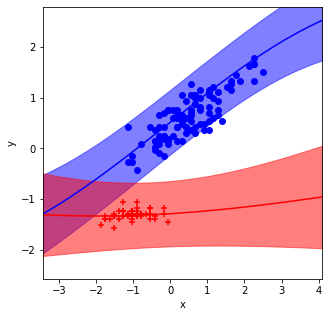

クラスタ数: 2
ARIの値: 0.5681159420289855
RMSEの値: [0.254581150034083, 0.09575856800531929]
MAEの値: [0.4501104325430999, 0.2681087600388838]
r2scoreの値: [0.7026747679850417, 0.03962507912388846]
実行時間: 6.913437128067017



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


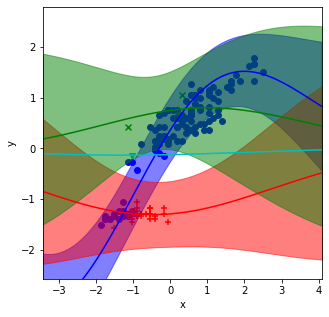

クラスタ数: 4
ARIの値: 0.22194512048353882
RMSEの値: [0.3540639401747785, 0.10199383489482329, 0.2739505604121177, 0.0183190625393439]
MAEの値: [0.5417732016275918, 0.27095472195069875, 0.4804569189992091, 0.13534793141878415]
r2scoreの値: [0.8171269079373502, -0.10068014727341579, -0.14880598724462235, nan]
実行時間: 7.563379287719727



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


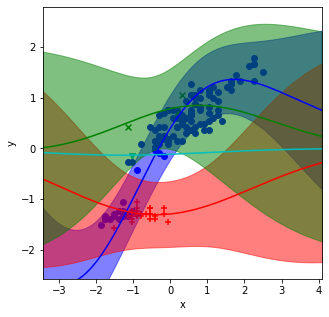

クラスタ数: 4
ARIの値: 0.22194512048353882
RMSEの値: [0.34918577812968027, 0.10304148461813738, 0.29422859315614913, 0.022332846990108457]
MAEの値: [0.5391547035202053, 0.27387452586237687, 0.49538238854969374, 0.14944178461898955]
r2scoreの値: [0.822131310083565, -0.12340798253047125, -0.32517140011673895, nan]
実行時間: 7.572781801223755



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


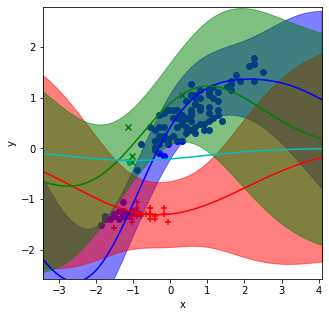

クラスタ数: 4
ARIの値: 0.2169821112675548
RMSEの値: [0.3309597319610309, 0.10416343329448978, 0.30926756051971505, 0.03462389704241636]
MAEの値: [0.5251343424042213, 0.2761134475433462, 0.5101037771579489, 0.18607497693783645]
r2scoreの値: [0.8414319329862093, -0.1480052203571891, 0.6132787872027103, nan]
実行時間: 7.441844940185547



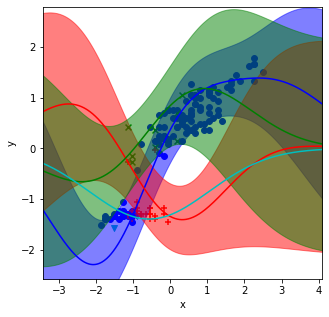

クラスタ数: 4
ARIの値: 0.1345269697052626
RMSEの値: [0.3252097903167561, 0.40776740268311434, 0.5677636067139163, 0.14405672716750867]
MAEの値: [0.5182822839039524, 0.5722570041932838, 0.6907518267548607, 0.3478917979266211]
r2scoreの値: [0.8674255927189641, -0.14480070906093445, -0.9012369880425859, -0.6059731449387165]
実行時間: 7.311991214752197



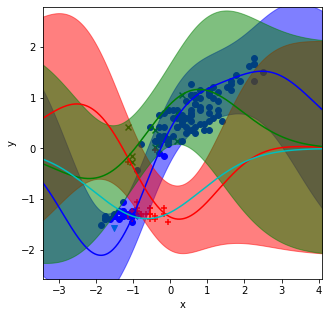

クラスタ数: 4
ARIの値: 0.12959238562505782
RMSEの値: [0.31967420547415387, 0.3956696856791528, 0.537763968858465, 0.12193562904616566]
MAEの値: [0.5128844179134271, 0.5604237917816393, 0.6830510166482444, 0.3169853149324579]
r2scoreの値: [0.8719004334445002, -0.045832968886324155, -0.7056289286346991, 0.013753107888667682]
実行時間: 7.189755916595459



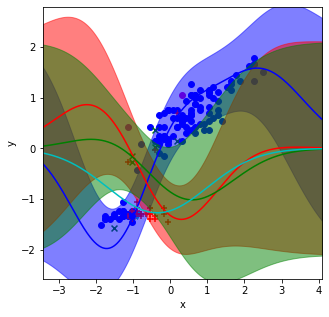

クラスタ数: 5
ARIの値: 0.11661191042634342
RMSEの値: [0.31465731404945346, 0.43260499928125257, 0.6363587179091366, 0.10669100810501463, 0.47250402612374237]
MAEの値: [0.5077789886156059, 0.59899151674747, 0.760559274725688, 0.2970166789491566, 0.6644618014931482]
r2scoreの値: [0.8758896119035733, 0.3087025681755795, 0.16248932126505677, -14.856207981461948, -1.2846350237809436]
実行時間: 7.219205856323242



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


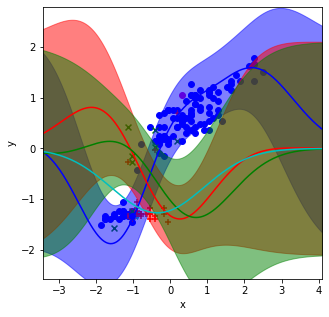

クラスタ数: 5
ARIの値: 0.1106515042200616
RMSEの値: [0.3102058202669134, 0.4129341674249522, 0.5993202936532601, 0.11583751266714021, 0.11275077730849858]
MAEの値: [0.5029671851030851, 0.5827883898478132, 0.717618719738996, 0.30893526303052155, 0.3357838252633658]
r2scoreの値: [0.8793763806568528, 0.39075499071851105, 0.3184466353030324, -17.69141341564912, nan]
実行時間: 7.4924890995025635



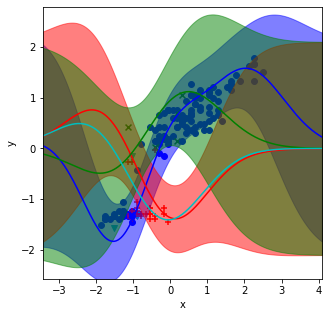

クラスタ数: 4
ARIの値: 0.11851963028279114
RMSEの値: [0.3127868576577332, 0.3698677943537631, 0.44221186525292877, 0.5940341848595364]
MAEの値: [0.5035551226406205, 0.5440676315212524, 0.6356383533318154, 0.6794176996988159]
r2scoreの値: [0.8762484862634697, 0.23941793074285633, -0.3960555238854411, -0.6432886690900836]
実行時間: 7.238373279571533



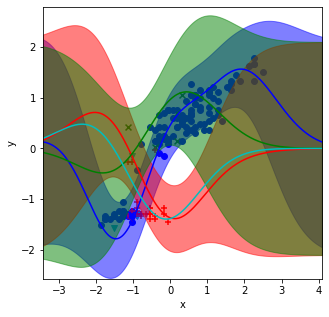

クラスタ数: 4
ARIの値: 0.11851963028279114
RMSEの値: [0.30891730705580833, 0.3702419592140084, 0.4515533361945213, 0.5807182518556804]
MAEの値: [0.5001701298037351, 0.5437398245354708, 0.6386153858717694, 0.6729335784360667]
r2scoreの値: [0.8792914573987674, 0.23787831560113393, -0.4556602391445128, -0.570442127122778]
実行時間: 7.191258192062378



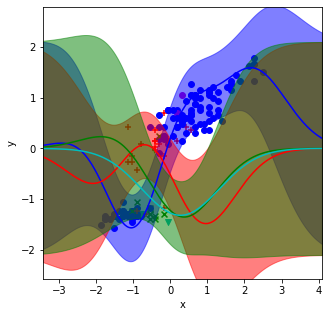

クラスタ数: 5
ARIの値: 0.0496135661029278
RMSEの値: [0.3371187138279534, 0.38775110795195633, 0.6745472150282634, 0.47962948614869416, 0.3419974082383533]
MAEの値: [0.521750093176715, 0.5586426299490199, 0.7717907139680898, 0.6868791565284683, 0.5369930428586677]
r2scoreの値: [0.8922207515167714, 0.44811041579022215, -1.4534117681357723, -30.649030657868202, -3.0228542925123634]
実行時間: 7.16987681388855



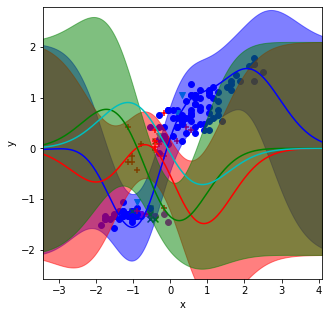

クラスタ数: 5
ARIの値: 0.0408457685930636
RMSEの値: [0.33400561767209114, 0.35681310465910865, 0.4978538609321115, 0.4679709396266619, 0.49305997018160924]
MAEの値: [0.519359294300231, 0.5383960009558338, 0.6582624997324755, 0.6175426176445694, 0.6697240020143503]
r2scoreの値: [0.8942021186190877, 0.5502053900490258, -0.08444741353306107, 0.6562129042517155, -54.33396159488946]
実行時間: 7.136641979217529



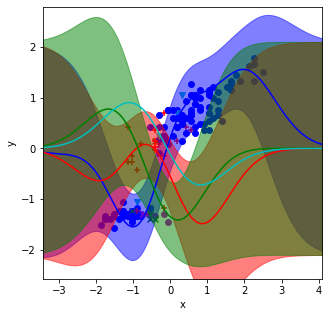

クラスタ数: 5
ARIの値: 0.0408457685930636
RMSEの値: [0.3310843615153058, 0.3595396374793976, 0.5082070389692436, 0.461816253381997, 0.5180233975594932]
MAEの値: [0.5174644522345867, 0.5395735947961483, 0.6652189759239998, 0.6143662455606089, 0.6872993850135914]
r2scoreの値: [0.8960446694321939, 0.5433050528856964, -0.13001989650332924, 0.6651963154611847, -60.078874545042204]
実行時間: 7.143464803695679



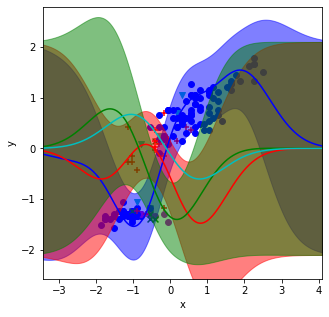

クラスタ数: 5
ARIの値: 0.03791365404817224
RMSEの値: [0.3281925385847097, 0.3207889585821108, 0.5180289272659793, 0.46099537835593635, 0.5410783927349747]
MAEの値: [0.515608124075833, 0.5148698988330865, 0.6713478517670606, 0.614954972124748, 0.7031912824202865]
r2scoreの値: [0.897852713388234, 0.6519686183360693, -0.17412074650086717, 0.5861561827695263, -65.6365734154007]
実行時間: 7.132633209228516



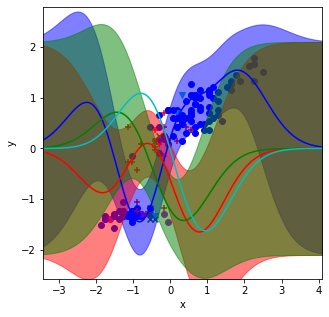

クラスタ数: 5
ARIの値: 0.03834414323951086
RMSEの値: [0.3267568487248948, 0.3935071980464716, 0.5590922132428117, 0.6068136989224029, 0.08304219109813074]
MAEの値: [0.5120227790095686, 0.5716811246701505, 0.6913560060028409, 0.6777340618977318, 0.23621156780988023]
r2scoreの値: [0.8983243124935896, 0.5221389675669901, 0.3286230348135111, 0.6686526566413094, -0.44995796828411416]
実行時間: 7.147053956985474



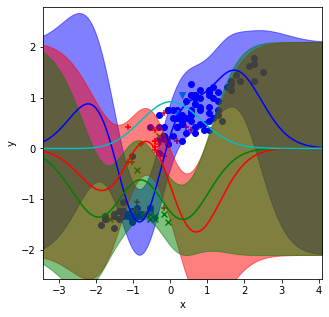

クラスタ数: 4
ARIの値: 0.04564287555339063
RMSEの値: [0.322296847762802, 0.3450181873338017, 0.6486586084788157, 0.39511104560321325]
MAEの値: [0.5089753228039482, 0.5342315849401902, 0.7744488704352669, 0.5692841313188479]
r2scoreの値: [0.8995224137329264, 0.6326185928355248, -1.1723716327742655, -4.369415532075403]
実行時間: 7.125430107116699



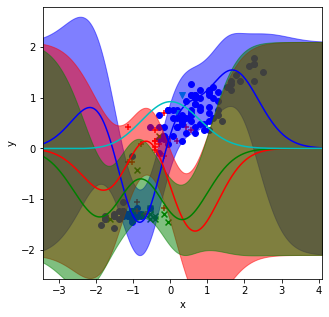

クラスタ数: 4
ARIの値: 0.04564287555339063
RMSEの値: [0.31901330262447747, 0.34565419904814587, 0.6594359020153452, 0.4042044468880791]
MAEの値: [0.5072999414662238, 0.5334551771715074, 0.7816942644047747, 0.5746190903241358]
r2scoreの値: [0.9015593065771877, 0.6312628715876609, -1.2451580907545226, -4.619411647411318]
実行時間: 7.121664047241211



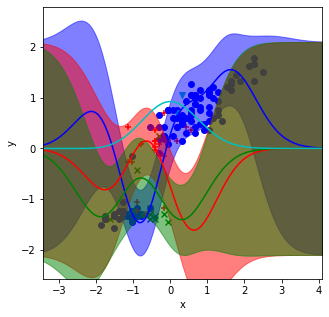

クラスタ数: 4
ARIの値: 0.04564287555339063
RMSEの値: [0.3160456300858388, 0.3461244017614031, 0.6693485000426244, 0.41286748253686106]
MAEの値: [0.5056907128069964, 0.5324584106331399, 0.788209085356312, 0.5796555370614063]
r2scoreの値: [0.9033823083247672, 0.630258983156437, -1.3131635484025392, -4.862866852997966]
実行時間: 7.160969972610474



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


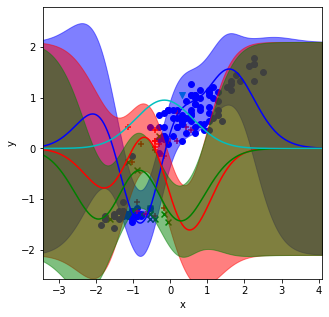

クラスタ数: 4
ARIの値: 0.04148389833567999
RMSEの値: [0.3191184659603173, 0.3621240428549268, 0.7178946500734166, 0.13897402620584365]
MAEの値: [0.5083168691790855, 0.5332731279099223, 0.8109465809171768, 0.37279220244774924]
r2scoreの値: [0.9008693057750433, 0.666132702144012, -1.1566388640785799, nan]
実行時間: 7.10126805305481



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


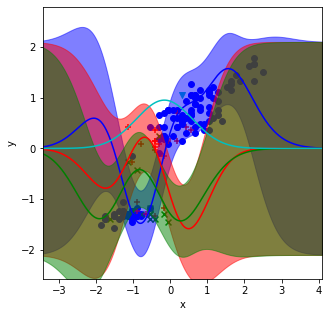

クラスタ数: 4
ARIの値: 0.04148389833567999
RMSEの値: [0.3166148421038861, 0.3604308058098004, 0.724927705604243, 0.1413211424862164]
MAEの値: [0.5071457668649432, 0.5309517573445285, 0.8145691668953042, 0.3759270441006026]
r2scoreの値: [0.9024186514483401, 0.6692476282087438, -1.1991020820264713, nan]
実行時間: 7.106343030929565



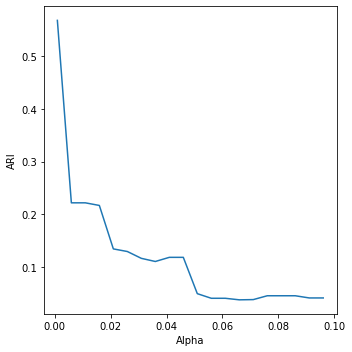

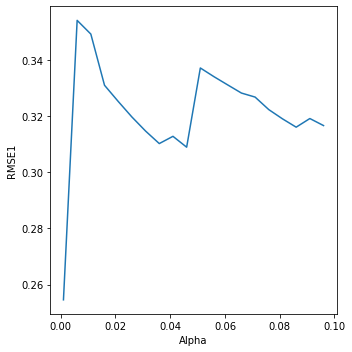

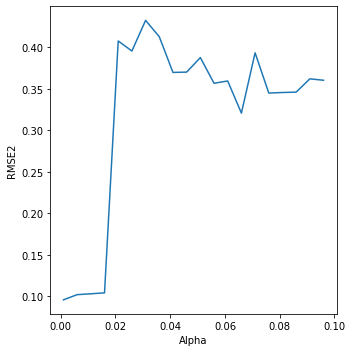

In [40]:
#-------------------
def make_path(model,main_path):
    folder_name =  "クラスタ数" + str(model.n_cluster) + "ARI" + str(round(model.ARI ,4)) + "ラムダ" + str(round(model.lam,4)) + "アルファ" + str(round(model.alpha,4))+ "ノイズ" + str(model.D)
    my_makedirs(main_path + "/" + folder_name)
    return main_path + "/" + folder_name + "/"
#-------------------

#-------------------
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
#-------------------

def plot(x,y,x_name,y_name,path):
    plt.figure(figsize=(5,5))
    plt.plot(x,y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.tight_layout()
    plt.savefig(os.path.join(path) + x_name +  "-" + y_name +".png")
    plt.show()
#-------------------

#-------------------
def RMSE_plot(ex_list,list_name,ex_RMSE_list,path):
    N = 3
    #バグ防止用処置 回帰線が2個以下の場合
    for i in range(len(ex_RMSE_list)):
        if len(ex_RMSE_list[i]) < 3:
            N = 2
        if len(ex_RMSE_list[i]) < 2:
            N = 1
            

    RMSE_list = np.zeros([N,len(ex_list)])
    for i in range(N):
        for k in range(len(ex_list)):
            RMSE_list[i,k] = ex_RMSE_list[k][i]
        plot(ex_list,RMSE_list[:][i],list_name,"RMSE"+str(i+1),path)
#-------------------

#-------------------
def main():
    t_all = time.time()
   
    #------------
    #
    #alpha_list = np.linspace(0.001,1, 1000)
    #lam_list = np.linspace(0.01,1,100)
    #D_list = np.linspace(1.5,3,0.5)
    
    #alpha_list = np.arange(0.01,1,0.01)
    #lam_list = np.arange(0.1,2,0.1)
    #D_list = np.arange(1.1,1.5,0.1)
    alpha_list = [0.00001,0.0001,0.001,0.01]
    alpha_list = np.arange(0.001,0.1,0.005)
    #alpha_list = [0.01,0.1,1,3,7,10,30]
    #alpha_list = [0.1]
    #lam_list = [0.0001,0.01,0.1,1,3,10,30]
    lam_list = [0.1]
    D_list = [3]
    #-----------
    #dataのパスを作成
    data_name = "iris_data"
    my_makedirs("./GPSCRM_result/" + data_name )
    my_makedirs("./GPSCRM_result/" + data_name + "/" + str(datetime.date.today()))
    main_path = "./GPSCRM_result/" + data_name + "/" + str(datetime.date.today())
    
    data = np.loadtxt("./data/"+ data_name +"/data.txt", dtype=float)
    #X = data[:,0]
    X = data[:,[0,1,3]]
    Y = data[:,2]
    labels = np.loadtxt("./data/"+ data_name +"/labels.txt")
    labels = np.array(labels)
    
    max_iter = 30
    random_seed = 50
    #lamを固定して，alphaとDについて，総当たりで実行する．
    #D_plot(X,Y,alpha_list,lam_list,D_list,labels,main_path,max_iter,random_seed)
    alpha_plot(X,Y,alpha_list,lam_list,D_list,labels,main_path,max_iter,random_seed)
    #lam_plot(X,Y,alpha_list,lam_list,D_list,labels,main_path,max_iter,random_seed)
    
    
    
    
#     count = 0
#     for l in range(len(D_list)):
#         for j in range(len(lam_list)):
#             alpha_ARI_list = []
#             alpha_RMSE_list = []
#             alpha_r2_score_list = []
#             time_list = []
#            
#             for i in range(len(alpha_list)):
#                 print(str(count + 1) + "回目の実行") 
#                 t1 = time.time()
#                 model = GPSCRM(X,Y,alpha_list[i],lam_list[j],D_list[l],labels,max_iter)
#                 model.fit()
#                 t2 = time.time()
#                 path = make_path(model,main_path)
#                 model.plot(model,path)
#                 model.print_info(model,t2-t1)
#                 alpha_ARI_list.append(model.ARI)
#                 alpha_RMSE_list.append(model.RMSE_list)
#                 alpha_r2_score_list.append(model.r2_score_list)
#                 time_list.append(t2 - t1)
#                 model.log_save(path,model,t2-t1)
#             plt_ARI(alpha_list,alpha_ARI_list,lam_list[j],D_list[l])
    
    # print(alpha_RMSE_list)
    # print("全ての実行時間:",time.time() - t_all)
#-------------------

#-------------------
if __name__ == "__main__":
    main()
#-------------------